<div style="background:cream; padding: 15px;">
    <h2 style="color: brown; text-align: center;">Exploratory Data Analysis and Baseline Model for Mechanisms of Action (MoA) Prediction</h2>
</div>

<center><img src="https://pharmacyinnovations.net/wp-content/uploads/pillsdrugs.png"></center>


<div style="background:cream; border: 4px double brown; padding: 10px;">
    <h2 style="color: brown; text-align: center;">Introduction</h2>
</div>


In the realm of pharmaceutical drug discovery, understanding the Mechanisms of Action (MoA) is pivotal for identifying effective treatments. This project delves into a comprehensive Exploratory Data Analysis (EDA) and establishes a baseline model for the MoA competition, employing tidy R, ggplot2, and machine learning techniques.

<div style="background:cream; padding: 8px;">
    <h2 style="color: brown; text-align: left;">Objective</h2>
</div>

The primary goal is to classify drugs based on their biological activity, a multi-label classification problem. The dataset encompasses responses from various human cell types to different drugs, with the challenge lying in predicting MoA class probabilities for unseen data.

In [1]:
import numpy as np
import pandas as pd
import random

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from category_encoders import CountEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.multioutput import MultiOutputClassifier

In [2]:
pd.options.display.max_columns = None

<div style="background:cream; border: 4px double brown; padding: 10px;">
    <h2 style="color: brown; text-align: center;">1. Data Overview</h2>
</div>

In [3]:
train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

train['dataset'] = 'train'
test['dataset'] = 'test'

df = pd.concat([train, test])

Take a look into training and test sets.

**train_features.csv** - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

In [4]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

**test_features.csv** - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

In [5]:
test.head()

sig_id      cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_0004d9e33       trt_cp       24      D1 -0.5458  0.1306 -0.5135  0.4408   
1  id_001897cda       trt_cp       72      D1 -0.1829  0.2320  1.2080 -0.4522   
2  id_002429b5b  ctl_vehicle       24      D1  0.1852 -0.1404 -0.3911  0.1310   
3  id_00276f245       trt_cp       24      D2  0.4828  0.1955  0.3825  0.4244   
4  id_0027f1083       trt_cp       48      D1 -0.3979 -1.2680  1.9130  0.2057   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0  1.5500 -0.1644 -0.2140  0.2221 -0.3260  1.9390 -0.2305 -0.3670  1.3040   
1 -0.3652 -0.3319 -1.8820  0.4022 -0.3528  0.1271  0.9303  0.3173 -1.0120   
2 -1.4380  0.2455 -0.3390 -0.3206  0.6944  0.5837 -0.0553 -0.6222  2.5430   
3 -0.5855 -1.2020  0.5998 -0.1799  0.9365  0.2942  1.3990 -1.1080  1.1610   
4 -0.5864 -0.0166  0.5128  0.6365  0.2611 -1.1120 -0.1747 -0.2053 -0.0006   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0  1.4610  0.0043  0.6816 -0.2304 -0.0635 -0.2030 -0.6821 -0.6242  0.1297   
1 -0.3213  0.0607 -0.5389 -0.8030 -1.0600 -0.0978 -0.8156 -0.6514  0.6812   
2 -0.7857  0.8163 -0.0495  0.1806  1.0290 -0.5204 -1.1070  0.7365 -0.3835   
3 -0.8134  0.0743 -0.3096 -0.9956  1.7100  1.2200 -0.1258 -0.5900 -0.7956   
4  0.0254  0.1784 -0.1314  1.0700  0.0477 -0.0756  0.1287  0.1403  0.7609   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -0.0338  0.3372  0.2254  0.4795  0.7642  0.6638 -0.2480 -0.1183 -0.4847   
1  0.5246  0.0000  0.5030 -0.1500 -0.1433  2.0910 -0.6556 -0.6012 -0.4104   
2 -0.5771  0.0523 -0.2690  0.1674  0.6010 -0.6660  0.0276  0.0924  0.2785   
3 -0.6765  0.0000 -0.8820  0.7609 -0.0882  0.5217  0.9587 -0.4764  0.2690   
4 -0.1095  0.0000 -1.0950 -0.0780  0.9048 -0.3007  0.4351 -0.1558  0.2101   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.0179 -0.8204 -0.5296 -1.5070 -0.0144  0.4448  0.5753 -0.2993 -0.9532   
1 -0.0580 -0.3608  0.2197 -0.7101  1.3430 -0.9605 -1.1920  0.3733  0.0216   
2 -0.3943 -0.4602 -0.0673 -1.3420  0.3127  0.3317  0.5176 -1.0830 -0.7108   
3  0.4753  0.0196  0.2775 -0.7142  0.7079  0.4006 -0.0175  0.5904 -0.1295   
4  0.4850  0.1139  0.6745 -0.9101 -0.6690  1.6320 -0.0910 -0.2841 -0.0883   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.1443 -1.0880  0.2080  0.5670  1.1190 -0.0455  0.2789 -1.0230 -0.6231   
1 -0.1787 -0.4277  1.2110  0.1401 -1.0940  0.7750  0.0000  2.3690 -0.1453   
2  0.8037 -0.1761 -0.5053 -0.1759 -0.1807 -0.2681  0.0284  0.9756 -0.5911   
3 -0.1021 -0.0480 -0.7627 -0.3995  0.2503 -1.9450  0.3880  0.1098  0.3617   
4  1.7570  2.0050 -0.8237  0.3234  0.2379 -1.4110 -0.1383  0.0630  0.2198   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0 -0.6682 -0.0718 -1.5240  0.9117  0.6883 -0.1073 -0.1134  0.4536  5.5140   
1 -1.0800 -1.1160 -0.1209  0.0668 -0.8654 -1.0150  0.5382  1.3060  0.2869   
2 -0.4490  1.7970 -0.1644 -0.6560 -0.1700 -0.1906  1.0820  0.3192  0.9073   
3 -0.3092  0.6467  0.0491 -0.3468  0.4760 -0.3444 -0.2431  1.0410  0.3487   
4 -0.5721  0.1917 -0.3863  0.1559  0.1903  0.4977  0.7420  1.1110  0.4917   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.3271  0.1388 -0.2321  1.5170  0.0546  0.9043 -0.3088  1.5360  0.1511   
1 -0.8135  0.4051  1.2760 -0.6459  0.5404 -0.1757 -0.0274  0.7104  0.8514   
2  0.4009  0.5121 -0.9755  0.1493 -0.0588 -0.5628 -0.0579 -1.0700 -0.3147   
3  0.9301 -0.3713 -0.4061 -0.5070  0.9324 -0.2296 -0.6001 -1.7580 -0.7311   
4 -0.0232  0.2063 -0.7254  0.5947  0.3108  0.6921  1.0250 -0.8283 -0.5511   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.3711 -0.0195 -0.4992  1.2080 -0.3614  0.7978  0.3076  0.5958  0.4006   
1  0.9873  0.7911 -0.3199  0.8688 -1.2900 -0.8000  0.6292 -1.2300 -0.2149   
2  0.2278 -0.9174  0.6609  1.0980  0.4891  0.6094 

In [6]:
print('Number of rows in training set:', train.shape[0])
print('Number of columns in training set:', train.shape[1] - 1)

print('Number of rows in test set:', test.shape[0])
print('Number of columns in test set:', test.shape[1] - 1)

Number of rows in training set: 23814
Number of columns in training set: 876
Number of rows in test set: 3982
Number of columns in test set: 876


In [7]:
# Display basic information about the datasets
print("Basic information of the dataset:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Basic information of the dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27796 entries, 0 to 3981
Columns: 877 entries, sig_id to dataset
dtypes: float64(872), int64(1), object(4)
memory usage: 186.2+ MB
None

Missing Values:
sig_id     0
cp_type    0
cp_time    0
cp_dose    0
g-0        0
          ..
c-96       0
c-97       0
c-98       0
c-99       0
dataset    0
Length: 877, dtype: int64


We can see that we have 872 float features 1 integer (cp_time) and 3 categorical (sig_id, cp_type and cp_dose).

In [8]:
sample_submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
sample_submission

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0     id_0004d9e33                          0.5                     0.5   
1     id_001897cda                          0.5                     0.5   
2     id_002429b5b                          0.5                     0.5   
3     id_00276f245                          0.5                     0.5   
4     id_0027f1083                          0.5                     0.5   
...            ...                          ...                     ...   
3977  id_ff7004b87                          0.5                     0.5   
3978  id_ff925dd0d                          0.5                     0.5   
3979  id_ffb710450                          0.5                     0.5   
3980  id_ffbb869f2                          0.5                     0.5   
3981  id_ffd5800b6                          0.5                     0.5   

      acat_inhibitor  acetylcholine_receptor_agonist  \
0                0.5                             0.5   
1                0.5                             0.5   
2                0.5                             0.5   
3                0.5                             0.5   
4                0.5                             0.5   
...              ...                             ...   
3977             0.5                             0.5   
3978             0.5                             0.5   
3979             0.5                             0.5   
3980             0.5                             0.5   
3981             0.5                             0.5   

      acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                   0.5                             0.5   
1                                   0.5                             0.5   
2                                   0.5                             0.5   
3                                   0.5                             0.5   
4                                   0.5                             0.5   
...                                 ...                             ...   
3977                                0.5                             0.5   
3978                                0.5                             0.5   
3979                                0.5                             0.5   
3980                                0.5                             0.5   
3981                                0.5                             0.5   

      adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                            0.5                            0.5   
1                            0.5                            0.5   
2                            0.5                            0.5   
3                            0.5                            0.5   
4                            0.5                            0.5   
...                          ...                            ...   
3977                         0.5                            0.5   
3978                         0.5                            0.5   
3979                         0.5                            0.5   
3980                         0.5                            0.5   
3981                         0.5                            0.5   

      adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
0                            0.5                          0.5   
1                            0.5                          0.5   
2                            0.5                          0.5   
3                            0.5                          0.5   
4                            0.5                          0.5   
...                          ...                          ...   
3977                         0.5                          0.5   
3978                         0.5                          0.5   
3979                         0.5                          0.5   
3980                         0.5                          0.5   
3981             

<div style="background:cream; border: 4px double brown; padding: 10px;">
    <h2 style="color: brown; text-align: center;">2. Data Visualization</h2>
</div>

<div style="background:cream; padding: 8px;">
    <h2 style="color: brown; text-align: left;">2.1 Categorical Features:</h2>
</div>

In [9]:
cp_width = 500
cp_height = 400
scatter_size = 600
WIDTH=800

In [10]:
selected_vars = ['cp_type', 'cp_time', 'cp_dose']

for i in selected_vars:
    df_i = df.groupby([i, 'dataset'])['sig_id'].count().reset_index()
    df_i.columns = [
        i,
        'dataset',
        'count'
    ]
    fig = px.bar(
        df_i,
        x = i,
        y='count',
        color='dataset',
        barmode='group',
        orientation='v', 
        title=f'{i} train/test counts', 
        width=cp_width,
        height=cp_height
    )
    fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning:

Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.



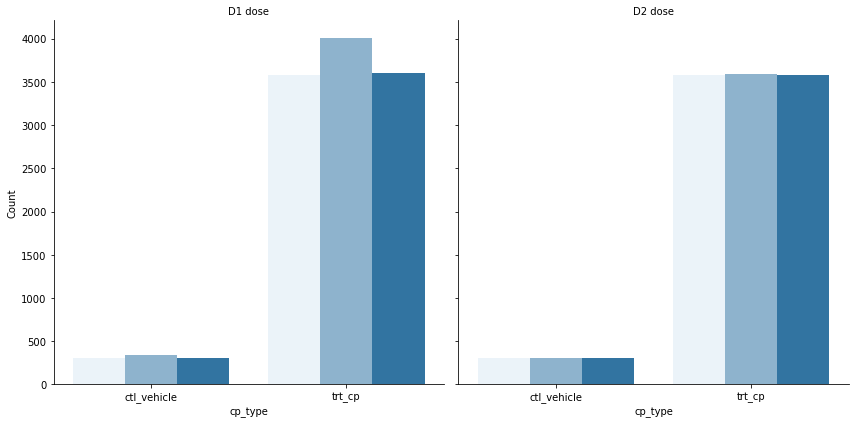

In [11]:
# Group by cp_type, cp_time, cp_dose, and count sig_id
ds = df[df['dataset'] == 'train']
ds = ds.groupby(['cp_type', 'cp_time', 'cp_dose'])['sig_id'].count().reset_index()

# Plot facet grid with bar charts
g = sns.FacetGrid(ds, col="cp_dose", height=6)
g.map(sns.barplot, "cp_type", "sig_id", "cp_time", ci=None)
g.set_axis_labels("cp_type", "Count")
g.set_titles(col_template="{col_name} dose")
plt.show()


<div style="background:cream; padding: 8px;">
    <h2 style="color: brown; text-align: left;">2.2 Gene and Cell Features:</h2>
</div>

In [12]:
train_columns = train.columns.to_list()

g_list = [i for i in train_columns if i.startswith('g-')]

c_list = [i for i in train_columns if i.startswith('c-')]

In [13]:
def plot_set_histograms(plot_list, title):
    fig = make_subplots(
        rows=4, 
        cols=3
    )
    
    traces = [
        go.Histogram(
            x=train[col], 
            nbinsx=100, 
            name=col
        ) for col in plot_list
    ]

    for i in range(len(traces)):
        fig.append_trace(
            traces[i], 
            (i // 3) + 1, 
            (i % 3) + 1
        )

    fig.update_layout(
        title_text=title,
        height=1000,
        width=WIDTH
    )
    fig.show()

In [14]:
plot_list = [
    g_list[
        np.random.randint(0, len(g_list)-1)
    ] for i in range(50)
]

plot_list = list(set(plot_list))[:12]
plot_set_histograms(plot_list, 'Randomly selected gene expression features distributions')

In [15]:
plot_list = [
    c_list[
        np.random.randint(0, len(c_list)-1)
    ] for i in range(50)
]

plot_list = list(set(plot_list))[:12]
plot_set_histograms(plot_list, 'Randomly selected cell expression features distributions')

<div style="background:cream; border: 4px double brown; padding: 10px;">
    <h2 style="color: brown; text-align: center;">3. Targets analysis</h2>
</div>

In [19]:
train_target = pd.read_csv("../input/lish-moa/train_targets_scored.csv")

print('Number of rows: ', train_target.shape[0])
print('Number of cols: ', train_target.shape[1])

train_target.head()

Number of rows:  23814
Number of cols:  207


sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   adrenergic_receptor_antagonist  akt_inhibitor  \
0                               0              0   
1                               0              0   
2                               0              0   
3                               0              0   
4                               0              0   

   aldehyde_dehydrogenase_inhibitor  alk_inhibitor  ampk_activator  analgesic  \
0                                 0              0               0          0   
1                                 0              0               0          0   
2                                 0              0               0          0   
3                                 0              0               0          0   
4                                 0              0               0          0   

   androgen_receptor_agonist  androgen_receptor_antagonist  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   anesthetic_-_local  angiogenesis_inhibitor  \
0                   0                       0   
1                   0                       0   
2                   0                       0   
3                   0                       0   
4                   0                       0   

   angiotensin_receptor_antagonist  anti-inflammatory  antiarrhythmic  \
0                                0                  0               0   
1                                0                  0               0   
2                                0                  0               0   
3                                0                  0               0   
4                                0                  0               0   

   antibiotic  anticonvulsant  antifungal  antihistamine  antimalarial  \
0           0               0           0              0             0   
1          

We can see that at least 50 target columns have number pf positive samples less than 20 (about 0.1%) !!!

In [20]:
x = train_target.drop(['sig_id'], axis=1).sum(axis=0).sort_values(ascending=False).reset_index()

x.columns = [
    'column', 
    'count'
]

x['count'] = x['count'] * 100 / len(train_target)

fig = px.bar(
    x, 
    x='column', 
    y='count', 
    orientation='v', 
    title='Percent of positive records for every column in target', 
    width=1200,
    height=800 
)

fig.show()

The biggest number of positive samples for 1 target column is 3.5%. So we deal here with highly imbalanced data.

In [22]:
data = train_target.drop(['sig_id'], axis=1).astype(bool).sum(axis=1).reset_index()

data.columns = [
    'row', 
    'count'
]

data = data.groupby(['count'])['row'].count().reset_index()

fig = px.pie(
    data, 
    values=100 * data['row'] / len(train_target), 
    names="count", 
    title='Number of activations in targets for every sample (Percent)', 
    width=WIDTH, 
    height=500
)

fig.show()

More than 50% have only one active target column.

 <div style="background:cream; border: 4px double brown; padding: 10px;">
    <h2 style="color: brown; text-align: center;">4. Baseline model - XGBoost</h2>
</div>

In this notebook, I establish a baseline model employing XGBoost and formulate the challenge as a binary classification problem. The problem is approached as a series of binary classification tasks, with the total number of classes being 206. To achieve this, I leverage the MultiOutputClassifier wrapper from the sklearn library.

In [24]:
SEED = 42
NFOLDS = 5
DATA_DIR = '/kaggle/input/lish-moa/'
np.random.seed(SEED)

In [25]:
train = pd.read_csv(DATA_DIR + 'train_features.csv')
targets = pd.read_csv(DATA_DIR + 'train_targets_scored.csv')

test = pd.read_csv(DATA_DIR + 'test_features.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

X = train[train.columns[1:]].values
X_test = test[test.columns[1:]].values
y = targets[targets.columns[1:]].values

In [26]:
classifier = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))

clf = Pipeline([('encode', CountEncoder(cols=[0, 2])),
                ('classify', classifier)
               ])

In [27]:
params = {'classify__estimator__colsample_bytree': 0.6522,
          'classify__estimator__gamma': 3.6975,
          'classify__estimator__learning_rate': 0.0503,
          'classify__estimator__max_delta_step': 2.0706,
          'classify__estimator__max_depth': 10,
          'classify__estimator__min_child_weight': 31.5800,
          'classify__estimator__n_estimators': 166,
          'classify__estimator__subsample': 0.8639
         }

_ = clf.set_params(**params)

In [28]:
oof_preds = np.zeros(y.shape)
test_preds = np.zeros((test.shape[0], y.shape[1]))
oof_losses = []
kf = KFold(n_splits=NFOLDS)
for fn, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print('Starting fold: ', fn)
    X_train, X_val = X[trn_idx], X[val_idx]
    y_train, y_val = y[trn_idx], y[val_idx]
    
    # drop where cp_type==ctl_vehicle (baseline)
    ctl_mask = X_train[:,0]=='ctl_vehicle'
    X_train = X_train[~ctl_mask,:]
    y_train = y_train[~ctl_mask]
    
    clf.fit(X_train, y_train)
    val_preds = clf.predict_proba(X_val) # list of preds per class
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class
    oof_preds[val_idx] = val_preds
    
    loss = log_loss(np.ravel(y_val), np.ravel(val_preds))
    oof_losses.append(loss)
    preds = clf.predict_proba(X_test)
    preds = np.array(preds)[:,:,1].T # take the positive class
    test_preds += preds / NFOLDS
    
print(oof_losses)
print('Mean OOF loss across folds', np.mean(oof_losses))
print('STD OOF loss across folds', np.std(oof_losses))

control_mask = train['cp_type']=='ctl_vehicle'
oof_preds[control_mask] = 0

print('OOF log loss: ', log_loss(np.ravel(y), np.ravel(oof_preds)))

Starting fold:  0


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Starting fold:  1


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Starting fold:  2


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Starting fold:  3


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Starting fold:  4


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[0.0169781773377249, 0.01704491710861325, 0.016865153552168475, 0.01700900926983899, 0.01717882474706338]
Mean OOF loss across folds 0.017015216403081797
STD OOF loss across folds 0.00010156682747757948
OOF log loss:  0.0167240932391125
